In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from architecture.classifier import DeepBinaryClassifier
from architecture.nodes.lut import make_lut_node

In [2]:
df   = pd.read_csv("./data/100_bit_artificial/1a.csv")
X = df.drop(columns="class").to_numpy(bool)
y = df["class"].to_numpy(bool)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(f"Dataset Shape               : {df.shape}")
print(f"Train-Test-Split            : {X_train.shape[0]} vs. {X_test.shape[0]}")
print(f"Train label distribution    : {y_train.sum()} (True) vs. {y_train.size - y_train.sum()} (False)")

Dataset Shape               : (10000, 101)
Train-Test-Split            : 8000 vs. 2000
Train label distribution    : 4605 (True) vs. 3395 (False)


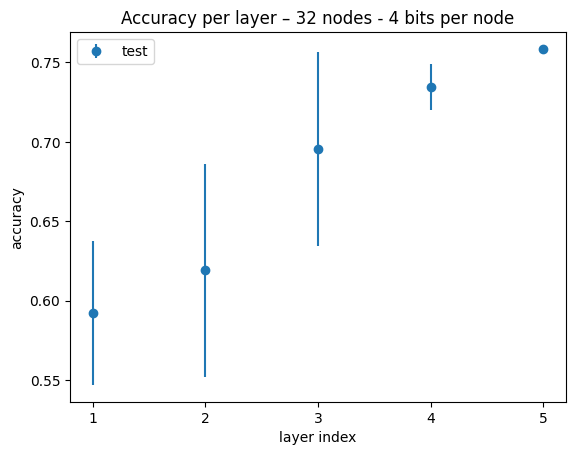

In [3]:
def get_layer_outputs(model, X: np.ndarray):
    """
    Return a list of per-layer outputs, each of shape (N, num_nodes_in_layer),
    honoring the model's backlinks (node-specific input selection).
    """
    if not model.layers:
        raise RuntimeError("Model not fitted")

    if X.dtype != bool:
        X = X.astype(bool, copy=False)

    input_dim = len(model.node_names[0])
    if X.shape[1] != input_dim:
        raise ValueError(f"X must have shape (N, {input_dim})")

    outputs = []
    layer_input = X
    for layer_idx, layer_nodes in enumerate(model.layers):
        layer_backlinks = model.backlinks[layer_idx + 1]  # backlinks for this layer
        layer_out = np.empty((layer_input.shape[0], len(layer_nodes)), dtype=bool)
        for j, (node, node_backlinks) in enumerate(zip(layer_nodes, layer_backlinks)):
            layer_out[:, j] = node(layer_input[:, node_backlinks])
        outputs.append(layer_out)
        layer_input = layer_out
    return outputs


def get_node_accuracies(model, X: np.ndarray, y: np.ndarray):
    """
    Return per-layer lists of node accuracies against y.
    """
    layer_outputs = get_layer_outputs(model, X)
    node_accuracies = []
    for layer_out in layer_outputs:
        accs = [accuracy_score(layer_out[:, j], y) for j in range(layer_out.shape[1])]
        node_accuracies.append(accs)
    return node_accuracies


# --- Example usage (your numbers) ---
hidden_layer_count  = 4
layer_node_count    = 32
layer_bit_count     = 4

lut_net = DeepBinaryClassifier(
    layer_node_counts = [layer_node_count]*hidden_layer_count + [1],
    layer_bit_counts  = [layer_bit_count]*(hidden_layer_count + 1),
    node_factory      = make_lut_node,
    seed              = 42
)
lut_net.fit(X_train, y_train)

node_train_accs = get_node_accuracies(lut_net, X_train, y_train)
layer_train_accs_mean = [np.mean(accs) for accs in node_train_accs]
layer_train_accs_std  = [np.std(accs)  for accs in node_train_accs]

node_test_accs = get_node_accuracies(lut_net, X_test, y_test)
layer_test_accs_mean = [np.mean(accs) for accs in node_test_accs]
layer_test_accs_std  = [np.std(accs)  for accs in node_test_accs]

# layers = hidden_layer_count + output layer
L = hidden_layer_count + 1
plt.errorbar(range(1, L+1), layer_test_accs_mean, yerr=layer_test_accs_std, fmt="o", label="test")
# plt.errorbar(range(1, L+1), layer_train_accs_mean, yerr=layer_train_accs_std, fmt="o", label="train")
plt.xticks(range(1, L+1))
plt.title(f"Accuracy per layer – {layer_node_count} nodes - {layer_bit_count} bits per node")
plt.xlabel("layer index")
plt.ylabel("accuracy")
plt.legend()
plt.show()

  4 nodes per layer: train 0.58  |  test 0.58
  8 nodes per layer: train 0.58  |  test 0.58
 16 nodes per layer: train 0.73  |  test 0.75
 32 nodes per layer: train 0.74  |  test 0.76
 64 nodes per layer: train 0.73  |  test 0.75
128 nodes per layer: train 0.79  |  test 0.78
256 nodes per layer: train 0.81  |  test 0.81


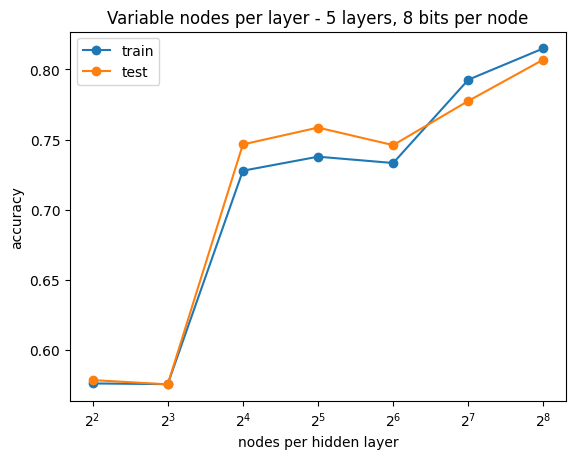

In [4]:
# Variable number of nodes per layer (fixed 8-bit iputs)

hidden_layer_count = 4
layer_node_counts  = [4, 8, 16, 32, 64, 128, 256]
layer_bit_count   = 4

train_acc, test_acc = [], []
for layer_node_count in layer_node_counts:
    lut_net = DeepBinaryClassifier(
        layer_node_counts   = [layer_node_count]*hidden_layer_count + [1],
        layer_bit_counts    = [layer_bit_count]*(hidden_layer_count + 1),
        node_factory        = make_lut_node,
        seed                = 42,
    )
    lut_net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, lut_net.predict(X_train)))
    test_acc.append(accuracy_score(y_test , lut_net.predict(X_test)))

    print(f"{layer_node_count:>3} nodes per layer: train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")

plt.plot(layer_node_counts, train_acc, marker="o", label="train")
plt.plot(layer_node_counts, test_acc , marker="o", label="test")
plt.title("Variable nodes per layer - 5 layers, 8 bits per node")
plt.xlabel("nodes per hidden layer")
plt.ylabel("accuracy")
plt.legend()
plt.xscale("log", base=2)
plt.show()

 2-bit nodes: train 0.58  |  test 0.58
 4-bit nodes: train 0.74  |  test 0.76
 6-bit nodes: train 0.76  |  test 0.74
 8-bit nodes: train 0.90  |  test 0.79
10-bit nodes: train 1.00  |  test 0.60
12-bit nodes: train 1.00  |  test 0.50
14-bit nodes: train 1.00  |  test 0.50
16-bit nodes: train 1.00  |  test 0.51
18-bit nodes: train 1.00  |  test 0.50
20-bit nodes: train 1.00  |  test 0.51


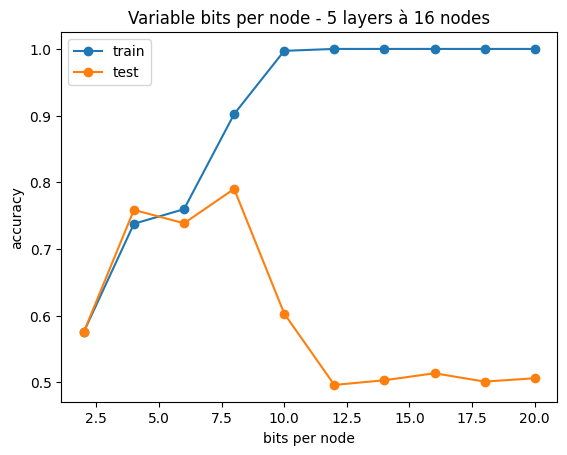

In [5]:
# Variable number of bits per node (fixed 16 nodes per layer)

hidden_layer_count  = 4
layer_node_count    = 32
layer_bit_counts    = [2, 4, 6, 8, 10, 12, 14, 16, 18, 20]

train_acc, test_acc = [], []
for layer_bit_count in layer_bit_counts:
    lut_net = DeepBinaryClassifier(
        layer_node_counts   = [layer_node_count]*hidden_layer_count + [1],
        layer_bit_counts    = [layer_bit_count]*(hidden_layer_count + 1),
        node_factory        = make_lut_node,
        seed                = 42,
    )
    lut_net.fit(X_train, y_train)
    train_acc.append(accuracy_score(y_train, lut_net.predict(X_train)))
    test_acc .append(accuracy_score(y_test , lut_net.predict(X_test)))

    print(f"{layer_bit_count:>2}-bit nodes: train {train_acc[-1]:.2f}  |  test {test_acc[-1]:.2f}")


plt.plot(layer_bit_counts, train_acc, marker="o", label="train")
plt.plot(layer_bit_counts, test_acc , marker="o", label="test")
plt.title("Variable bits per node - 5 layers à 16 nodes")
plt.xlabel("bits per node")
plt.ylabel("accuracy")
plt.legend()
plt.show()